## ICESat-2 ATL03 SlideRule Download

This code is adapted from Sliderule Python example code. It is designed to pull ALT03 points for a region of interest and save those elevations as a CSV. 

Activate the sliderule_env enviroment to run

Last updated by Karina Zikan July 2023

In [1]:
# import h5py
# import shapely
# import geopandas
# import pandas

In [1]:
import sys
import time
import logging
import sliderule
import pandas as pd
import geopandas as gpd
import concurrent.futures
from datetime import datetime
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import sliderule, icesat2, earthdata, h5

## SlideRule Configuration

In [2]:
# Configure ICESat-2 API
icesat2.init("slideruleearth.io", verbose=False)

## Specify Region of Interest

#### 1. Make geojson from shapefile - if you have a geojson of the region skip to 2.

In [3]:
# Specify region of interest shapefile
shp = "/Users/titus/BSU/remote_sensing/tutorials/icesat2/karina/RCEW-outline_WGS84.shp"
shapefile = gpd.read_file(shp)
# shapefile.to_file('DryCreek/boundDCEW/boundDCEW_WGS84.geojson', driver='GeoJSON')
shapefile.crs is None

False

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the Reynolds Creek shapefile
reynolds_creek = gpd.read_file(shp)

# Load the USA boundaries shapefile (from Natural Earth data)
usa = gpd.read_file("/Users/titus/BSU/remote_sensing/carbon_estimation/code/icesat2/data_prep/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# Check CRS consistency
usa = usa.to_crs(reynolds_creek.crs)

# Filter Idaho boundary from the USA geometries
idaho = usa[usa['NAME'] == 'Idaho']  # Use the correct column name for state names

# Ensure Idaho geometry is valid
if idaho.empty:
    raise ValueError("Idaho boundary is not found in the USA dataset.")
idaho = idaho.buffer(0)  # Fix any invalid geometries if present

# Plot the maps
fig, axs = plt.subplots(1, 3, figsize=(18, 8), gridspec_kw={'width_ratios': [1, 1, 2]})

# --- Plot USA map highlighting Idaho ---
axs[0].set_title("USA Map with Idaho Highlighted", fontsize=12)
usa.plot(ax=axs[0], color='lightgrey', edgecolor='black', linewidth=0.5)
idaho.plot(ax=axs[0], color='blue', edgecolor='black', alpha=0.6, label="Idaho")
axs[0].legend(fontsize=8)
axs[0].set_aspect("equal")  # Explicit aspect ratio
axs[0].axis('off')

# --- Plot Idaho map highlighting RCEW ---
axs[1].set_title("Idaho with Reynolds Creek Highlighted", fontsize=12)
idaho.plot(ax=axs[1], color='lightblue', edgecolor='black')
reynolds_creek.plot(ax=axs[1], color='green', edgecolor='black', alpha=0.8, label="Reynolds Creek")
axs[1].legend(fontsize=8)
axs[1].set_aspect("equal")  # Explicit aspect ratio
axs[1].axis('off')

# --- Plot zoomed-in Reynolds Creek map ---
axs[2].set_title("Reynolds Creek Experimental Watershed", fontsize=12)
reynolds_creek.plot(ax=axs[2], color='lightgreen', edgecolor='black', linewidth=0.8)
axs[2].grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
axs[2].set_aspect("equal")  # Explicit aspect ratio
axs[2].axis('on')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


ValueError: Idaho boundary is not found in the USA dataset.

##### - Check shapefile crs

In [24]:
## if shapefile.crs is None is false check the crs
shapefile.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

##### - Make Geojson

In [25]:
# shapefile.to_file('Sites/RCEW/ROIs/RCEW-outline_WGS84.geojson', driver='GeoJSON')

In [26]:
## if shapefile.crs is None is true run this section
#crs = 'epsg:8826' # set the starting datum using the epsg code
#icesat_crs = 4979 # epsg code for WGS84
#shapefile = shapefile.set_crs(crs)
#shapefile = shapefile.to_crs(icesat_crs) # transform to WGS84 
#shapefile.to_file('/Mores/MCSboundary/MoresBound_WGS84.geojson', driver='GeoJSON')

In [27]:
## if shapefile.crs is not WGS84 run this section
#icesat_crs = 4979 # epsg code for WGS84
#shapefile = shapefile.to_crs(icesat_crs) # transform to WGS84 
#shapefile.to_file('/Mores/MCSboundary/MoresBound_WGS84.geojson', driver='GeoJSON')

#### 2. Read in geojson for Region of Interest

In [28]:
# Specify region of interest from geojson
poly_fn = '/Users/titus/BSU/remote_sensing/tutorials/icesat2/karina/RCEW-outline_WGS84.geojson'
region = sliderule.toregion(poly_fn)["poly"] # symplify 
region

[{'lon': -116.799, 'lat': 43.06089},
 {'lon': -116.7954, 'lat': 43.06089},
 {'lon': -116.7481, 'lat': 43.06268},
 {'lon': -116.747, 'lat': 43.06295},
 {'lon': -116.7411, 'lat': 43.06456},
 {'lon': -116.7409, 'lat': 43.06469},
 {'lon': -116.7392, 'lat': 43.06591},
 {'lon': -116.7379, 'lat': 43.06712},
 {'lon': -116.7179, 'lat': 43.09706},
 {'lon': -116.7008, 'lat': 43.12889},
 {'lon': -116.6963, 'lat': 43.13834},
 {'lon': -116.696, 'lat': 43.13915},
 {'lon': -116.6922, 'lat': 43.15454},
 {'lon': -116.6881, 'lat': 43.22341},
 {'lon': -116.6881, 'lat': 43.22476},
 {'lon': -116.6947, 'lat': 43.24693},
 {'lon': -116.6954, 'lat': 43.24828},
 {'lon': -116.6958, 'lat': 43.24883},
 {'lon': -116.702, 'lat': 43.2564},
 {'lon': -116.7022, 'lat': 43.25654},
 {'lon': -116.7579, 'lat': 43.2872},
 {'lon': -116.7605, 'lat': 43.28828},
 {'lon': -116.7612, 'lat': 43.28856},
 {'lon': -116.8199, 'lat': 43.31163},
 {'lon': -116.8251, 'lat': 43.31298},
 {'lon': -116.8266, 'lat': 43.31218},
 {'lon': -116.8303

In [29]:
# Prepare coordinate lists for plotting the region of interest polygon
region_lon = [e["lon"] for e in region]
region_lat = [e["lat"] for e in region]

/var/folders/fx/2fdk1gcs15x1chhn56kqjpl40000gp/T/ipykernel_7621/2724123891.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


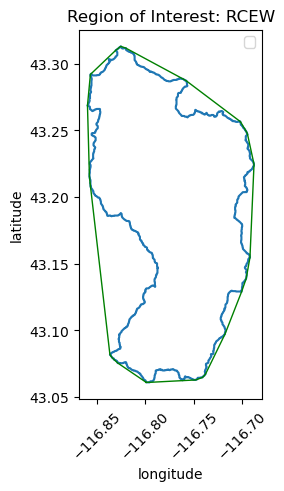

In [34]:
# Read geojson with geopandas
pregion = gpd.read_file(poly_fn)
map = pregion.plot(); # plot origonal boundery 
map.plot(region_lon, region_lat, linewidth=1, color='g'); # plot symplified region boundery for a sanity check
plt.title("Region of Interest: RCEW")
plt.xlabel("longitude")
plt.xticks(rotation=45)
plt.ylabel("latitude")
plt.legend()
plt.show()

#### 3. Save simplified polygon

In [11]:
polygon_geom = Polygon(zip(region_lon, region_lat))
crs = 'epsg:4979'
polygon = gpd.GeoDataFrame(index=[0], geometry=[polygon_geom])       

polygon

,geometry
0,"POLYGON ((-116.799 43.06089, -116.7954 43.0608..."


### Save to file if you haven't already

In [12]:
# polygon.to_file('/Users/titus/BSU/remote_sensing/tutorials/icesat2/karina/RCEW-outline_WGS84_simple.geojson', driver='GeoJSON')

# Sliderule Product processing

Follow the processing section for the desired product

### ATL03 processing

#### ATL03 Parameters

In [17]:
parms = {
    "poly": region,
    "srt": 0,
    # "atl08_class": "atl08_ground",
    "cnf": icesat2.CNF_BACKGROUND, 
    "ats": 20.0,
    "cnt": 10, 
    "len": 40.0,
    "res": 20.0,
    "maxi": 6,
    "t0": '2021-05-01T00:00:00Z',
    "t1": '2021-07-31T00:00:00Z',
    # all land classification flags
    "atl08_class": ["atl08_noise", "atl08_ground", "atl08_canopy", "atl08_top_of_canopy", "atl08_unclassified"], #the photon’s ATL08 classification (0: noise, 1: ground, 2: canopy, 3: top of canopy, 4: unclassified)
    "atl08_fields": ["asr", "ph_count"],#, "gnd_count", "veg_count", "h_te_median", "h_max_canopy", "h_min_canopy", "h_mean_canopy", "h_canopy", "canopy_openness", "canopy_h_metrics"],
    # all photons
    "yapc": dict(knn=0, win_h=6, win_x=11, min_ph=4, score=0)
}
cvs_name = "/Users/titus/BSU/remote_sensing/carbon_estimation/data/icesat2_data/rcew_icesat2_atl03_may21_jul21.csv" #set name of the output

#### Calculate Elevations

In [18]:
# Latch Start Time
perf_start = time.perf_counter()

# Request ATL06 Data
data = icesat2.atl03sp(parm=parms, keep_id=True)

# Latch Stop Time
perf_stop = time.perf_counter()

# Display Statistics
perf_duration = perf_stop - perf_start
print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
#print("Reference Ground Tracks: {}".format(atl06_sr["rgt"].unique()))
#print("Cycles: {}".format(atl06_sr["cycle"].unique()))
print("Received {} elevations".format(data.shape[0]))

Completed in 3.629 seconds of wall-clock time
Received 0 elevations


In [19]:
# data[data["extent_id"] == 2256304266937373687]

## Data Check

In [20]:
#Set utmzone code - utm zone 11:32611
utm_code = 'epsg:32611' 

data['Longitude'] = data['geometry'].x
data['Latitude'] = data['geometry'].y
eastnorths = data['geometry'].to_crs(utm_code)
data['Easting'] = eastnorths.x
data['Northing'] = eastnorths.y
data

,geometry,Longitude,Latitude,Easting,Northing


## Write CSV - ATL03

#### filter to summer months

In [16]:
import datetime 

In [ ]:
data['Date'] = pd.to_datetime(data.index)
# data = data[(data['Date'].dt.month >= 5) & (data['Date'].dt.month <= 9)]
# data[1:6]

In [18]:
data_xyz = pd.DataFrame()

data_xyz['X'] = data['Easting']
data_xyz['Y'] = data['Northing']
data_xyz['Z'] = data['height']
data_xyz['rgt'] = data['rgt']
data_xyz['time'] = data['Date']

data_xyz = data_xyz.set_index('time')
data_xyz

,X,Y,Z,rgt
time,,,,
2021-05-23 01:47:15.202137344,519746.413226,4.767772e+06,2285.228271,905
2021-05-23 01:47:15.202137344,519731.651653,4.767774e+06,1409.943481,905
2021-05-23 01:47:15.202137344,519731.607092,4.767774e+06,1407.301758,905
2021-05-23 01:47:15.202137344,519732.776858,4.767774e+06,1476.653687,905
2021-05-23 01:47:15.202137344,519735.321417,4.767773e+06,1627.518799,905
...,...,...,...,...
2021-07-26 10:58:40.421562368,516386.659587,4.767597e+06,1933.636841,501
2021-07-26 10:58:40.421662464,516383.620890,4.767596e+06,2079.876465,501
2021-07-26 10:58:40.422062336,516383.308067,4.767593e+06,2079.514893,501


#### Write CSV

In [ ]:
# cvs_name = "/Users/titus/BSU/remote_sensing/carbon_estimation/data/icesat2_data/rcew_icesat2_atl03_may21_jul21_new.csv"
# data.to_csv(cvs_name)

#### Write to geojson

In [ ]:
# outName = cvs_name.replace('.csv', '.geojson')  # Create an output file name using the input file name
# outName

'/Users/titus/BSU/remote_sensing/carbon_estimation/data/icesat2_data/rcew_icesat2_atl03_may21_jul21_new.geojson'

In [ ]:
# data.to_file(outName, driver='GeoJSON')  # Export to GeoJSON

In [ ]:
# https://www.google.com/search?sca_esv=a9478bc663a38991&sxsrf=ADLYWIKWZM4JM8vb3Jd92AaiaLxzWpIr7w:1733598520882&q=reynolds+creek&udm=2&fbs=AEQNm0Aa4sjWe7Rqy32pFwRj0UkW1DRbm01j6DCVS0r1sTxn7h_rt6mVhwDmwtd3hPZjM8yExIiDaiXmTUfySTHDiZj3UTG80EwhSyTroYFQj8tF7zcMoE0nv4MRgKjnjU6XL0Bjk1Svlhd4nn4UkKwmovIsZpLcMeV9jSKK5Rv4VPkDgkOC4Xh5VJHjvxxiXdS4M2HmJBUw6WBbL57pSPurSR8M88tK1w&sa=X&sqi=2&ved=2ahUKEwiHwJTgrZaKAxWUAjQIHSYYAVcQtKgLegQIFBAB&biw=1600&bih=838&dpr=1.8#imgrc=ItWx4oFl66r4-M&imgdii=KhDDaBxMccWF8M

